In [1]:
from __future__ import print_function
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [2]:
california_housing_dataframe = pd.read_csv(
    "https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

In [3]:
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe['median_house_value'] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
16233,-122.5,37.7,47.0,2382.0,392.0,867.0,376.0,5.3,371.5
53,-115.5,33.0,32.0,1615.0,382.0,1307.0,345.0,1.5,58.6
10675,-120.6,35.1,39.0,1656.0,333.0,866.0,317.0,2.9,195.2
10074,-119.8,36.7,25.0,1717.0,542.0,1343.0,471.0,0.8,51.8
8109,-118.4,34.2,36.0,1488.0,313.0,1221.0,296.0,4.0,171.4
...,...,...,...,...,...,...,...,...,...
2835,-117.7,34.1,26.0,6459.0,894.0,2487.0,885.0,6.2,261.8
4307,-118.0,33.9,34.0,1653.0,292.0,1003.0,310.0,4.6,203.4
897,-117.1,32.8,20.0,1989.0,508.0,1452.0,462.0,2.0,118.3
3921,-118.0,34.1,28.0,2831.0,552.0,2330.0,557.0,4.0,173.1


In [4]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


In [5]:
my_feature = california_housing_dataframe[['total_rooms']]
feature_columns = [tf.feature_column.numeric_column('total_rooms')]

In [6]:
targets = california_housing_dataframe['median_house_value']

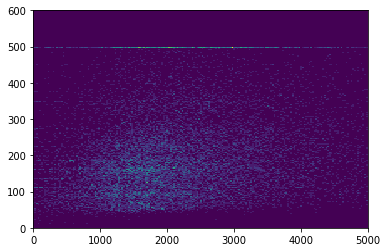

In [7]:
rooms_value_hist = plt.hist2d(california_housing_dataframe['total_rooms'], 
                               california_housing_dataframe['median_house_value'],
                              bins = 200,
                             range=[[0,5000],[0,600]])

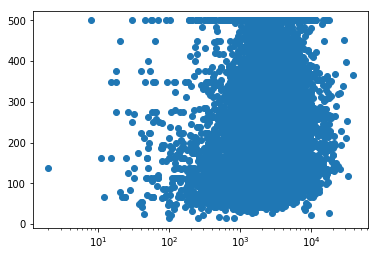

In [8]:
rooms_value_scatter = plt.scatter(california_housing_dataframe['total_rooms'], 
                                california_housing_dataframe['median_house_value'],
                                marker = 'o')
plt.xscale('log')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a344b7b38>]],
      dtype=object)

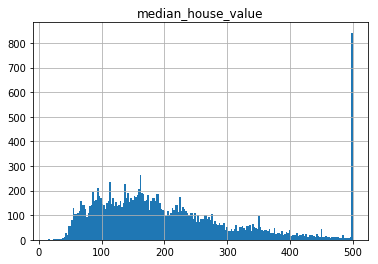

In [9]:
california_housing_dataframe.hist('median_house_value',bins = 200)

In [10]:
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate = .000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer,5.0)

linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [11]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key:np.array(value) for key,value in dict(features).items()}
    ds = Dataset.from_tensor_slices((features,targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
        
    features,labels = ds.make_one_shot_iterator().get_next()
    return features,labels

In [12]:
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature,targets),
    steps = 100)

In [13]:
prediction_input_fn = lambda:my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)
predictions = linear_regressor.predict(input_fn = prediction_input_fn)
predictions = np.array([item['predictions'][0] for item in predictions])

mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("MSE: %0.3f"% mean_squared_error)
print("RMS: %0.3f"% root_mean_squared_error)

MSE: 55846.894
RMS: 236.319


In [14]:
min_house_value = california_housing_dataframe['median_house_value'].min()
max_house_value = california_housing_dataframe['median_house_value'].max()
min_max_diff = max_house_value - min_house_value

print('Min: %.3f'% min_house_value)
print('Max: %.3f'% max_house_value)
print('Diff: %.3f' % min_max_diff)
print("RMS: %0.3f"% root_mean_squared_error)

Min: 14.999
Max: 500.001
Diff: 485.002
RMS: 236.319


In [15]:
calibration_data = pd.DataFrame()
calibration_data['predictions'] = pd.Series(predictions)
calibration_data['targets'] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,1.3,207.3
std,1.1,116.0
min,0.0,15.0
25%,0.7,119.4
50%,1.1,180.4
75%,1.6,265.0
max,19.0,500.0


In [16]:
sample = california_housing_dataframe.sample(n=100)

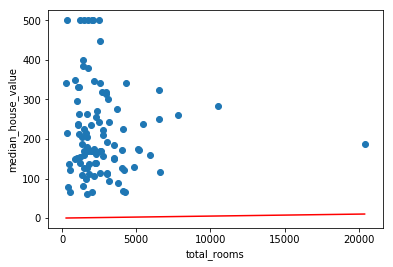

In [17]:
x_0 = sample['total_rooms'].min()
x_1 = sample['total_rooms'].max()

weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

y_0 = weight*x_0 + bias
y_1 = weight*x_1 + bias

plt.plot([x_0,x_1],[y_0,y_1], c='r')

plt.ylabel('median_house_value')
plt.xlabel('total_rooms')

plt.scatter(sample['total_rooms'], sample['median_house_value'])

plt.show()

In [20]:
def train_model(learning_rate, steps, batch_size, input_feature='total_rooms'):
    periods = 10
    steps_per_period = steps/periods
    
    my_feature = input_feature
    my_feature_data = california_housing_dataframe[[my_feature]]
    my_label = 'median_house_value'
    targets = california_housing_dataframe[my_label]
    
    feature_colums = [tf.feature_column.numeric_column(my_feature)]
    
    training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
    prediction_input_fn = lambda:my_input_fn(my_feature_data, targets, num_epochs=1,shuffle=False)
    
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer,5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns,
        optimizer=my_optimizer
    )
    
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.title('Learned Line by Period')
    plt.ylabel(my_label)
    plt.xlabel(my_feature)
    sample = california_housing_dataframe.sample(n=300)
    plt.scatter(sample[my_feature],sample[my_label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1,1,periods)]
    
    print("Training model...")
    print("RMSE (on training data):")
    root_mean_squared_errors = []
    for period in range(0,periods):
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        
        predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])
        
        root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(predictions,targets))
        print("  period %02d : %0.2f" % (period, root_mean_squared_error))
        root_mean_squared_errors.append(root_mean_squared_error)
        y_extents = np.array([0,sample[my_label].max()])
        
        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
        
        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents,sample[my_feature].max()),
                              sample[my_feature].min())
        y_extents = weight*x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period])
    print("Model training finished.")
    
    plt.subplot(1,2,2)
    plt.ylabel("RMS")
    plt.xlabel("Periods")
    plt.title("RMS vs Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)
    
    calibration_data = pd.DataFrame()
    calibration_data['predictions'] = pd.Series(predictions)
    calibration_data['targets'] = pd.Series(targets)
    display.display(calibration_data.describe())

    print("Final RMS (on training data): %02.f" % root_mean_squared_error)
        
        
    

Training model...
RMSE (on training data):
  period 00 : 225.63
  period 01 : 214.42
  period 02 : 204.04
  period 03 : 194.62
  period 04 : 186.29
  period 05 : 186.29
  period 06 : 179.23
  period 07 : 173.57
  period 08 : 169.46
  period 09 : 167.02
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,119.0,207.3
std,98.1,116.0
min,0.1,15.0
25%,65.8,119.4
50%,95.7,180.4
75%,141.8,265.0
max,1707.2,500.0


Final RMS (on training data): 167


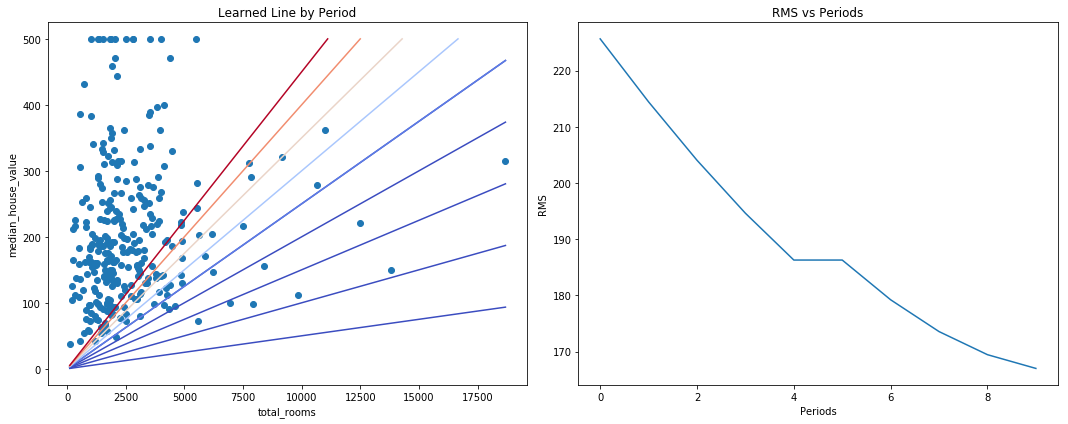

In [21]:
train_model(learning_rate=.0005,
           steps=20,
           batch_size=5
)

In [31]:
def train_model2(learning_rate, steps, batch_size, input_feature="total_rooms"):
    periods = 10
    steps_per_period = steps / periods

    my_feature = input_feature
    my_feature_data = california_housing_dataframe[[my_feature]]
    my_label = "median_house_value"
    targets = california_housing_dataframe[my_label]

    # Create feature columns.
    feature_columns = [tf.feature_column.numeric_column(my_feature)]

    # Create input functions.
    training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
    prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)

    # Create a linear regressor object.
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns,
        optimizer=my_optimizer
    )

    # Set up to plot the state of our model's line each period.
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title("Learned Line by Period")
    plt.ylabel(my_label)
    plt.xlabel(my_feature)
    sample = california_housing_dataframe.sample(n=300)
    plt.scatter(sample[my_feature], sample[my_label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    root_mean_squared_errors = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        linear_regressor.train(input_fn=training_input_fn,steps=steps_per_period)
        # Take a break and compute predictions.
        predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])

        # Compute loss.
        root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(predictions, targets))
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        root_mean_squared_errors.append(root_mean_squared_error)
        # Finally, track the weights and biases over time.
        # Apply some math to ensure that the data and line are plotted neatly.
        y_extents = np.array([0, sample[my_label].max()])

        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents,
                                          sample[my_feature].max()),
                               sample[my_feature].min())
        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period]) 
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)

    # Output a table with calibration data.
    calibration_data = pd.DataFrame()
    calibration_data["predictions"] = pd.Series(predictions)
    calibration_data["targets"] = pd.Series(targets)
    display.display(calibration_data.describe())

    print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

Training model...
RMSE (on training data):
  period 00 : 209.51
  period 01 : 188.58
  period 02 : 178.67
  period 03 : 176.00
  period 04 : 183.22
  period 05 : 189.16
  period 06 : 189.16
  period 07 : 189.16
  period 08 : 185.99
  period 09 : 183.22
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,164.4,207.3
std,132.0,116.0
min,0.3,15.0
25%,90.8,119.4
50%,134.2,180.4
75%,197.9,265.0
max,4103.4,500.0


Final RMSE (on training data): 183.22


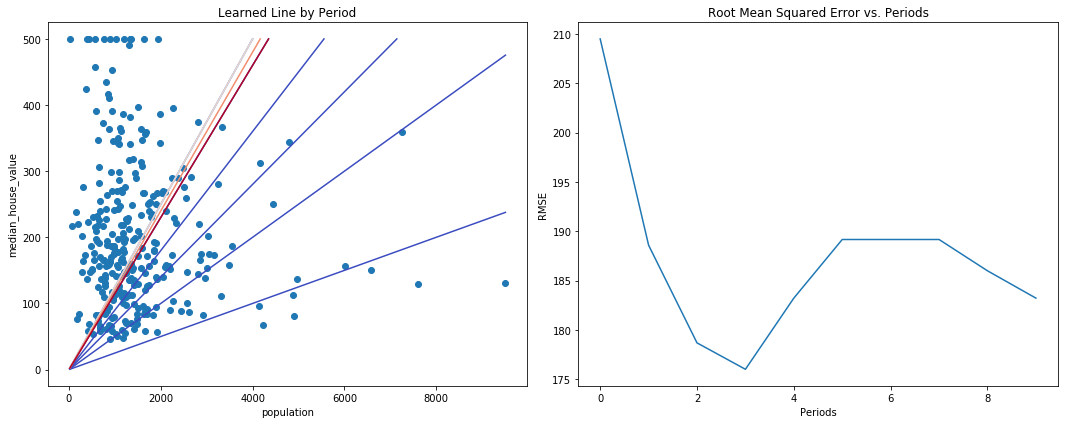

In [32]:
train_model2(learning_rate=.0005,
        steps=100,
        batch_size=5,
        input_feature='population'
)